## Importing code, loading, and subsetting data columns.

In [23]:
from util import *
from sklearn.preprocessing import scale
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


df_ppg = pd.read_csv(
    'data/PPG_FOG_NEUROCOM_FINAL_v2.csv',
    index_col=0
)

df_ppg.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,75.0,5.500000,4.176026,0.500000,3.000000,4.000000,8.000000,20.000000
moca,75.0,25.720000,2.555122,15.000000,24.000000,26.000000,27.000000,30.000000
educ_year,75.0,15.906667,2.781082,10.000000,13.000000,16.000000,18.000000,20.000000
age,75.0,65.426667,6.670170,51.000000,61.500000,65.000000,71.000000,78.000000
updrs_iii,75.0,29.786667,11.882924,8.000000,21.250000,27.500000,38.000000,66.000000
led_calculation,75.0,628.456667,496.431457,0.000000,300.000000,600.000000,800.000000,3180.000000
weight,75.0,82.542000,17.521470,53.100000,70.875000,79.650000,92.250000,140.400000
height,75.0,172.906267,9.056852,149.860000,167.005000,172.720000,178.435000,194.310000
striatal_dtbz,75.0,1.923322,0.254270,1.458417,1.736458,1.902567,2.054354,2.570067
has_fog,75.0,0.213333,0.412420,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
df_es = df_ppg.filter(regex='has_fog|ES[0-9]+').astype(float)

print(df_es.shape)

(75, 7)


## Plotting the  equillibrium score (ES) boxplots for guiding comparisons.

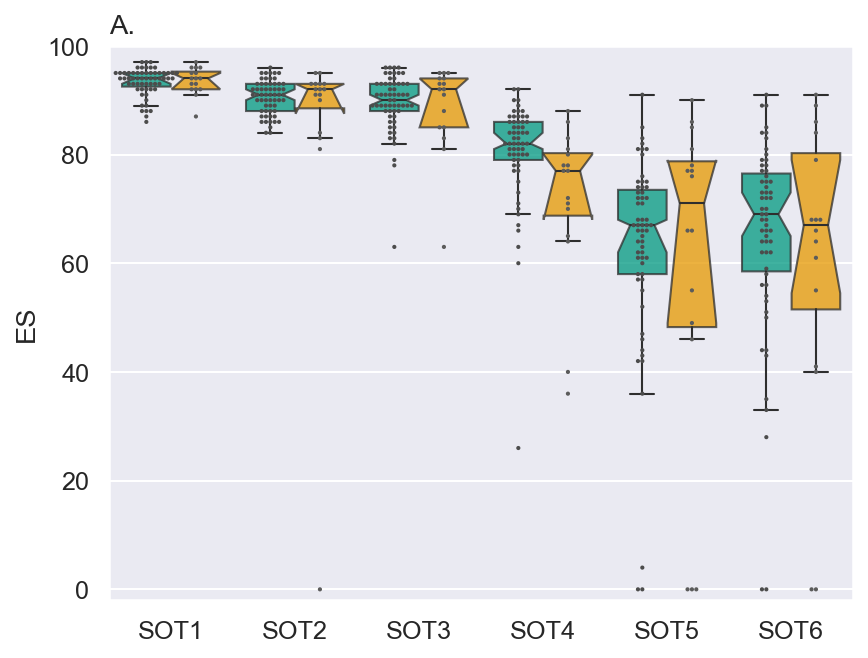

In [9]:
df_es_boxplot = df_es.assign(
    has_fog = df_es.has_fog.replace({0.0: 'Non-freezers', 1.0: 'Freezers'})
).rename({
    'has_fog': 'Group'
}, axis=1).rename(
    lambda col: col.replace('ES', 'SOT'),
    axis=1
)

df_es_boxplot = df_es_boxplot.melt(['Group'], ['SOT1', 'SOT2', 'SOT3', 'SOT4', 'SOT5', 'SOT6']).rename({
    'value': 'ES',
    'variable': 'Condition'
}, axis=1)

sns.set(font_scale=1.1)

palette = {"Freezers": (0.9, 0.6, 0.0, 0.0),
           "Non-freezers": (0.0, 0.6, 0.5, 0.0)}

plt.figure(dpi=150)

sns.boxplot(
    data=df_es_boxplot,
    x='Condition',
    y='ES',
    hue='Group',
    palette=palette,
    fliersize=0,
    notch=True,
    bootstrap=10000,
    saturation=1,
    linewidth=1,
    boxprops=dict(alpha=.75)
)

sns.swarmplot(
    data=df_es_boxplot,
    x='Condition',
    y='ES',
    hue='Group',
    size=1,
    dodge=True,
    linewidth=1,
    edgecolor='gray'
)

plt.legend([], [], frameon=False)
plt.xlabel('')
plt.title('A.', loc='left')
plt.ylim(-2, 100)
plt.show()

ES under SOT4 (eyes open, sway-referenced surface) is chosen as the focus of comparison because it is the only condition for which bootstrapped 95% confidence intervals for the median demonstrated minimal overlap.

## Comparing non-freezers (0) and freezers (1) on ES under SOT4 


 ES4 
---


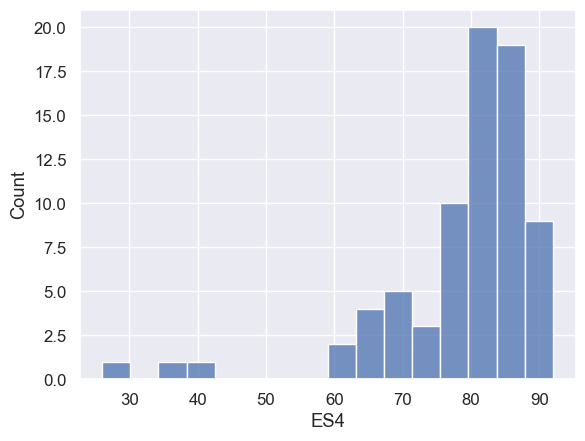

Non-freezers: 82.0±7.0
Freezers: 77.0±11.5

Result:
 W=696.5

P= 0.004*


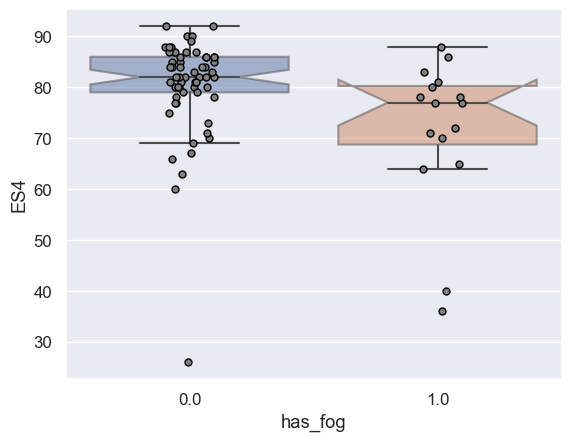

In [10]:
_ = numvar_comparison(
    df_es, 'has_fog', 'ES4', pvalround=3,
    boxprops=dict(alpha=.5),
    notch=True
)

## Plotting ES condition sensory contrast boxplots for guiding comparisons.

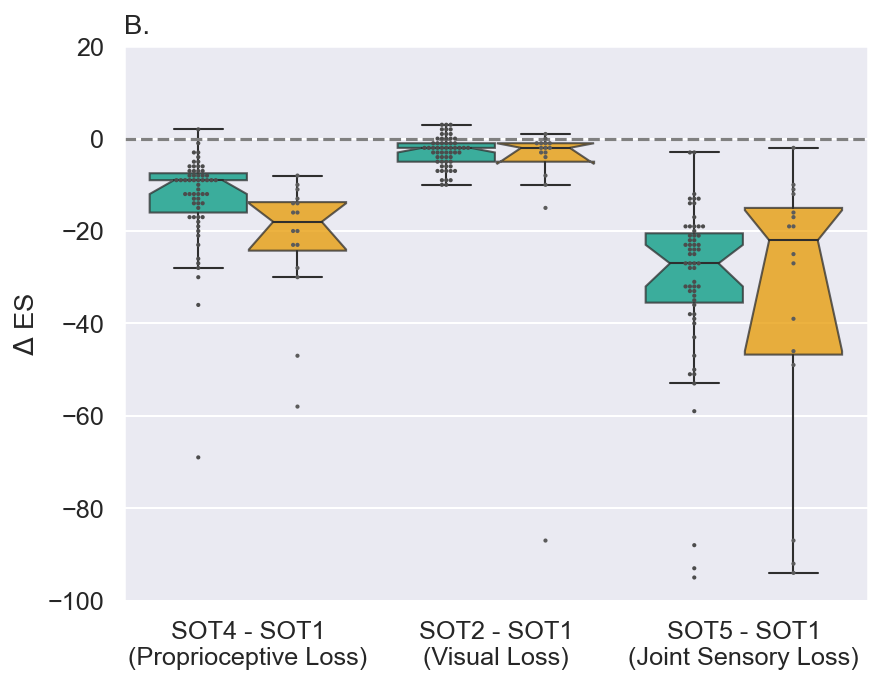

In [12]:
df_diff_template = pd.DataFrame({'Group': df_ppg.has_fog.replace({0.0: 'Non-freezers', 1.0: 'Freezers'})})

df_diff_contrasts = pd.concat([
    df_diff_template.assign(**{'Difference': df_ppg.ES4 - df_ppg.ES1, 'Contrast': 'SOT4 - SOT1\n(Proprioceptive Loss)'}),
    df_diff_template.assign(**{'Difference': df_ppg.ES2 - df_ppg.ES1, 'Contrast': 'SOT2 - SOT1\n(Visual Loss)'}),
    df_diff_template.assign(**{'Difference': df_ppg.ES5 - df_ppg.ES1, 'Contrast': 'SOT5 - SOT1\n(Joint Sensory Loss)'})
])

plt.figure(dpi=150)

ax = sns.boxplot(
    data=df_diff_contrasts,
    x='Contrast',
    y='Difference',
    hue='Group',
    dodge=True,
    palette=palette,
    fliersize=0,
    notch=True,
    bootstrap=10000,
    saturation=1,
    linewidth=1,
    boxprops=dict(alpha=.75),
)

sns.swarmplot(
    data=df_diff_contrasts,
    x='Contrast',
    y='Difference',
    hue='Group',
    size=1,
    dodge=True,
    linewidth=1,
    edgecolor='gray'
)
ax.legend([], [], frameon=False)
plt.xlabel('')
plt.ylim(-100, 20)
plt.ylabel('$\Delta$ ES')
plt.axhline(0, color='gray', linestyle='dashed')
plt.title('B.', loc='left')
plt.show()

## Comparing non-freezers (0) and freezers (1) on proprioceptive loss contrast score 



 SOT4 - SOT1
(Proprioceptive Loss) 
---


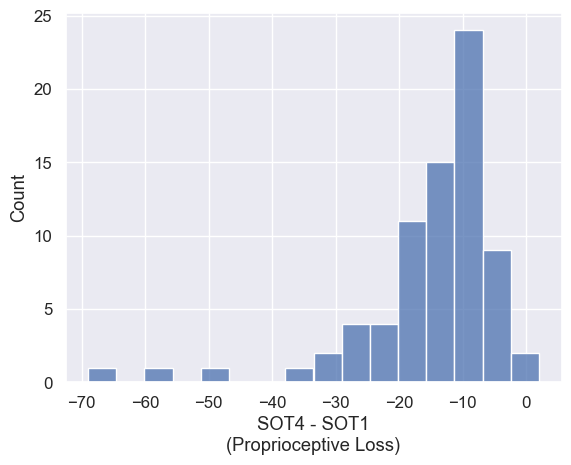

Non-freezers: -9.0±8.5
Freezers: -18.0±10.5

Result:
 W=723.5

P= 0.001*


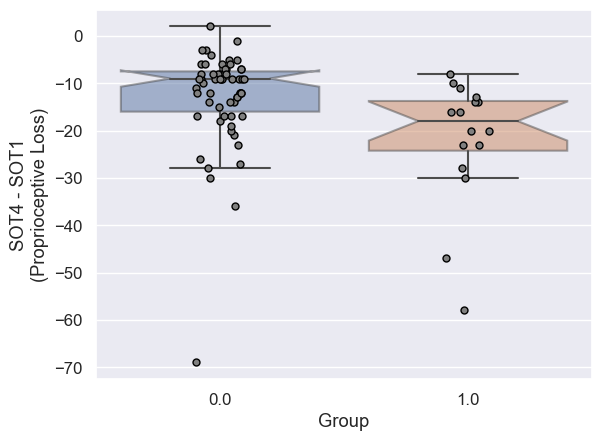

In [13]:
df_es_contrasts = df_diff_contrasts.reset_index().pivot(
    index=['ID', 'Group'],
    columns='Contrast',
    values='Difference'
).reset_index().set_index('ID')

df_es_contrasts = df_es_contrasts.assign(
    Group = df_es_contrasts.Group.replace({'Non-freezers': 0.0, 'Freezers': 1.0})
)

_ = numvar_comparison(
    df_es_contrasts, 'Group', 'SOT4 - SOT1\n(Proprioceptive Loss)', pvalround=3,
    boxprops=dict(alpha=.5),
    notch=True
)

## Running Cross-Validated Logistic LASSO Regression

In [25]:
df_cop_sot4 = pd.read_csv('data/PPG_COP_measures.csv', index_col=0)
df_cop_sot4.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_value_ML,75.0,0.019573,0.984917,-2.202780,-0.706323,0.035855,0.777630,2.760776
mean_value_AP,75.0,0.062657,0.878270,-2.042276,-0.514802,0.078765,0.730678,1.882875
mean_distance_ML,75.0,-0.048438,0.911590,-1.531924,-0.673911,-0.114476,0.565328,2.251334
mean_distance_AP,75.0,0.016371,1.067349,-1.060649,-0.547152,-0.289673,0.118727,6.139127
mean_distance_Radius,75.0,0.014690,1.062125,-1.106976,-0.519773,-0.218463,0.155671,6.092641
maximal_distance_ML,75.0,-0.062622,0.956266,-1.516450,-0.723468,-0.159199,0.200109,3.280692
maximal_distance_AP,75.0,0.035648,1.077484,-1.343204,-0.709925,-0.296979,0.489843,4.222020
maximal_distance_Radius,75.0,0.035221,1.075671,-1.354728,-0.717600,-0.252849,0.477524,4.206756
rms_ML,75.0,-0.052245,0.914331,-1.553483,-0.701667,-0.106720,0.469635,2.413497
rms_AP,75.0,0.025004,1.072048,-1.116537,-0.550497,-0.264388,0.087253,5.598674



        Cutoff: 0.3507118565911965
        Accuracy: 0.84
        Sensitivity: 0.5
        Specificity: 0.9322033898305084
        
fractal_dimension_ML_AND_AP                      -0.145323
LFS_ML_AND_AP                                    -0.053005
frequency_dispersion_Power_Spectrum_Density_ML   -0.033775
maximal_distance_Radius                           0.089463
total_power_Power_Spectrum_Density_ML             0.191333
critical_displacement_Diffusion_AP                0.419477
dtype: float64


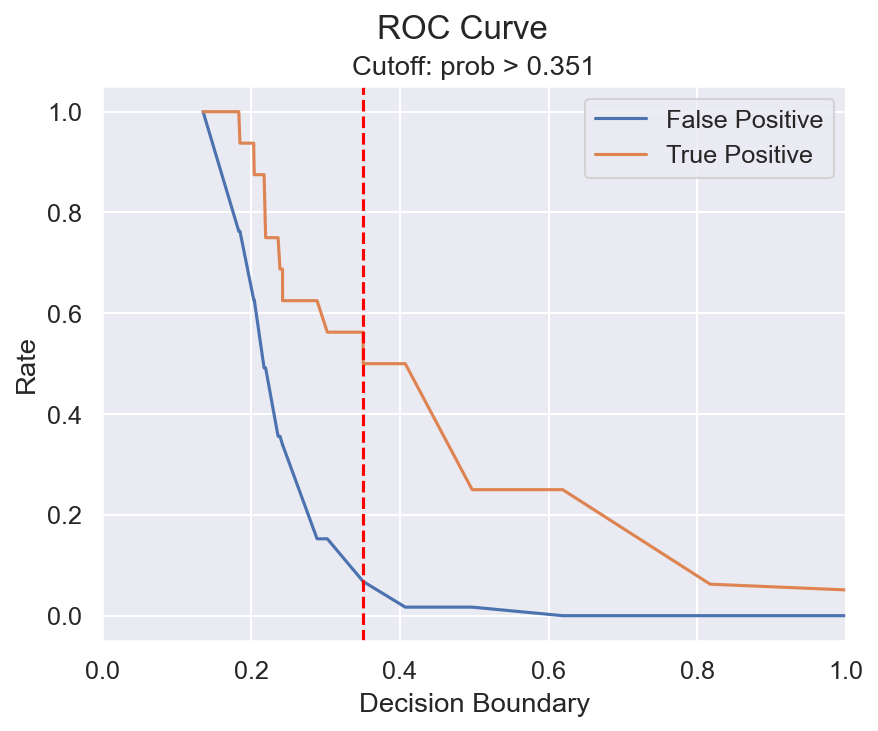

In [16]:
model_lasso_cop_sot4 = logistic_lasso(
    df_cop_sot4,
    response='has_fog',
    n_jobs=-1
)

bench_lasso_cop_sot4 = model_lasso_cop_sot4.benchmark_model()
print(bench_lasso_cop_sot4)
_ = bench_lasso_cop_sot4.plot_roc_curve()
print(model_lasso_cop_sot4.coef)

## Boxplot to guide stabilogram diffusion analysis sensory contrast comparisons

In [17]:
df_sda_contrast = pd.read_csv('data/PPG_SDA_contrast.csv', index_col=0).loc[df_cop_sot4.index]
df_sda_contrast.describe().T

,count,mean,std,min,25%,50%,75%,max
$D_{yl}$,75.0,1.017680,1.356376,-0.954188,0.200291,0.554385,1.326863,6.421363
$D_{ys}$,75.0,1.086190,1.273222,-0.807818,0.304210,0.578651,1.502826,7.445272
$H_{yl}$,75.0,0.160393,1.304491,-3.280562,-0.783610,0.377813,0.961176,2.688012
$H_{ys}$,75.0,0.311707,0.830230,-1.159463,-0.277250,0.102700,0.676545,3.443095
$\Delta t_{yc}$,75.0,0.049816,1.300652,-1.934285,-0.523290,-0.069432,0.310110,6.689339
${\langle \Delta y^2 \rangle}_c$,75.0,0.786183,1.472843,-0.664039,0.014586,0.242805,0.825306,8.836502


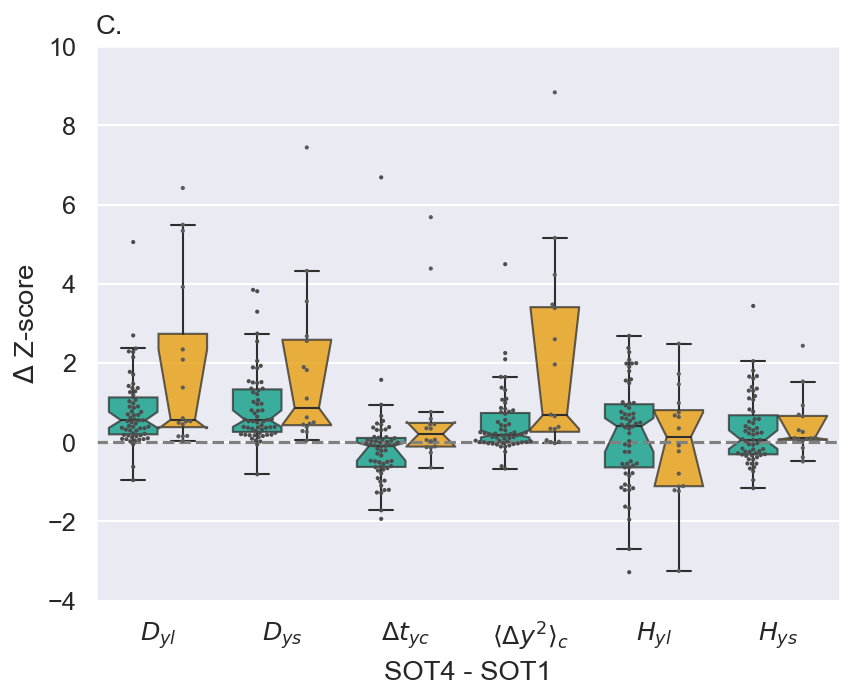

In [24]:
df_sda_contrast_boxplots = df_sda_contrast.melt(
    id_vars=['Group']
).rename({
    'variable': 'SOT4 - SOT1',
    'value': 'Z-Score Difference'
}, axis=1)

plt.figure(dpi=150)
ax = sns.boxplot(
    data=df_sda_contrast_boxplots,
    x='SOT4 - SOT1',
    y='Z-Score Difference',
    hue='Group',
    order=[r'$D_{yl}$', r'$D_{ys}$', r'$\Delta t_{yc}$', r'${\langle \Delta y^2 \rangle}_c$', r'$H_{yl}$', '$H_{ys}$'],
    dodge=True,
    palette=palette,
    fliersize=0,
    notch=True,
    bootstrap=10000,
    saturation=1,
    linewidth=1,
    boxprops=dict(alpha=.75)
)

sns.swarmplot(
    data=df_sda_contrast_boxplots,
    x='SOT4 - SOT1',
    y='Z-Score Difference',
    hue='Group',
    order=[r'$D_{yl}$', r'$D_{ys}$', r'$\Delta t_{yc}$', r'${\langle \Delta y^2 \rangle}_c$', r'$H_{yl}$', '$H_{ys}$'],
    size=1,
    dodge=True,
    linewidth=1,
    edgecolor='gray'
)
plt.ylabel('$\Delta$ Z-score')
plt.ylim(-4, 10)
plt.title('C.', loc='left')
plt.axhline(0, color='gray', linestyle='dashed')
handles = ax.get_legend_handles_labels()
ax.legend([], [], frameon=False)
plt.show()

## $\Delta t_{yc}$ comparison

Critical time in AP axis comparison by freezer or non-freezer.


 $\Delta t_{yc}$ 
---


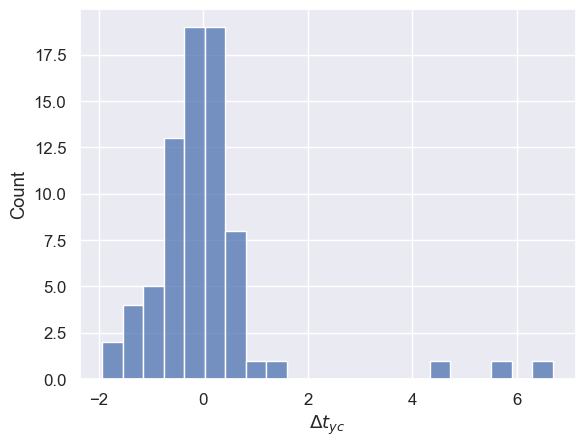

Non-freezers: -0.092±0.733
Freezers: 0.205±0.598

Result:
 W=267.0

P= 0.008*


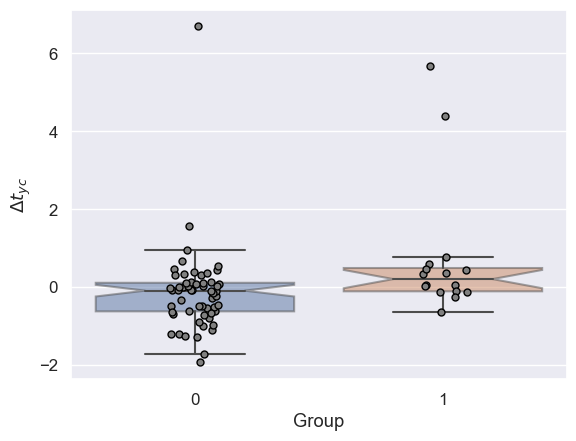

In [26]:
_ = numvar_comparison(
    df_sda_contrast.replace({'Non-freezers': 0, 'Freezers': 1}),
    'Group',
    r'$\Delta t_{yc}$',
    pvalround=3,
    descround=3,
    boxprops=dict(alpha=0.5),
    notch=True
)

## ${\langle \Delta y^2 \rangle}_c$ comparison

Critical mean square displacement in AP axis by freezer or non-freezer.


 ${\langle \Delta y^2 \rangle}_c$ 
---


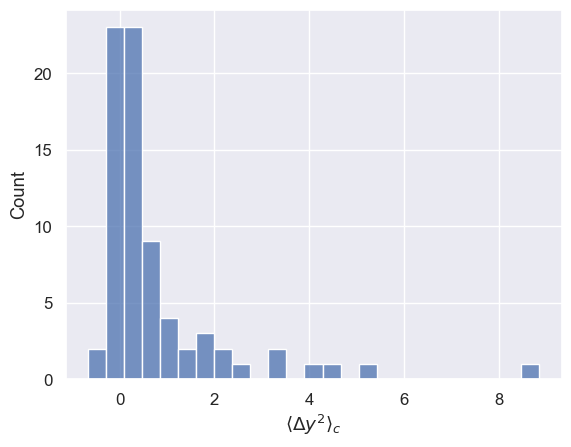

Non-freezers: 0.19±0.74
Freezers: 0.68±3.15

Result:
 W=275.0

P= 0.011*


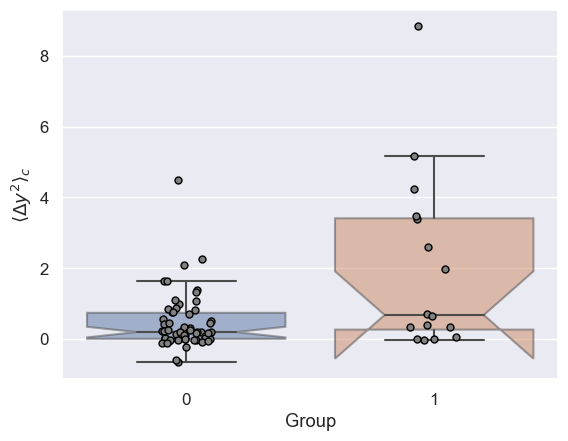

In [27]:
_ = numvar_comparison(
    df_sda_contrast.replace({'Non-freezers': 0, 'Freezers': 1}),
    'Group',
    r'${\langle \Delta y^2 \rangle}_c$',
    pvalround=3,
    descround=2,
    boxprops=dict(alpha=0.5),
    notch=True
)

## Preparing data for logistic confounder regression

In [28]:
# JOINING THE RELEVANT POSTUROGRAPHY VARIABLES
df_reg_posture = df_es_contrasts[['SOT4 - SOT1\n(Proprioceptive Loss)']].rename({
    'SOT4 - SOT1\n(Proprioceptive Loss)': 'ES_SOT4_SOT1_contrast'
}, axis=1).assign(
    SDA_CRITDISP_SOT4_SOT1_contrast = df_sda_contrast[r'${\langle \Delta y^2 \rangle}_c$']
)
# SCALE THE RELEVANT POSTUROGRAPHY VARIABLES
df_reg_posture.iloc[:,:] = scale(df_reg_posture)

# READ IN THE RELEVANT COVARIATES
df_reg_covariates = pd.read_csv('data/PPG_FOG_NEUROCOM.csv', index_col=0)[[
    'striatal_dtbz',
    'moca',
    'educ_year',
    'led_calculation',
    'ACB_cutoff',
    'updrs_iii',
    'clinical_balance_impaired',
    'has_fog'
]]

# NUMERIC COVARIATES TO SCALE AND CENTER
numeric_covariates = [
    'striatal_dtbz',
    'moca',
    'educ_year',
    'led_calculation',
    'updrs_iii'
]
# SCALING AND CENTERING NUMERIC COVARIATES
df_reg_covariates[numeric_covariates] = scale(df_reg_covariates[numeric_covariates])

# JOINING RELEVANT POSTUROGRAPHY VARIABLES AND COVARIATES
df_reg = df_reg_posture.join(df_reg_covariates)

df_reg.describe().T

,count,mean,std,min,25%,50%,75%,max
ES_SOT4_SOT1_contrast,75.0,-8.511710e-18,1.006734,-4.665250,-0.229128,0.244633,0.589186,1.450569
SDA_CRITDISP_SOT4_SOT1_contrast,75.0,8.955799e-17,1.006734,-0.991272,-0.527411,-0.371415,0.026742,5.502645
striatal_dtbz,75.0,-6.870430e-16,1.006734,-1.840707,-0.739854,-0.082179,0.518795,2.560662
moca,75.0,4.796163e-16,1.006734,-4.223747,-0.677691,0.110322,0.504328,1.686347
educ_year,75.0,1.236048e-16,1.006734,-2.138176,-1.052195,0.033786,0.757774,1.481761
led_calculation,75.0,-1.110223e-16,1.006734,-1.274474,-0.666091,-0.057708,0.347880,5.174381
updrs_iii,75.0,1.258253e-16,1.006734,-1.845790,-0.723236,-0.193729,0.695842,3.068033
has_fog,75.0,2.133333e-01,0.412420,0.000000,0.000000,0.000000,0.000000,1.000000


In [29]:
model_measure_comparison = logistic_hierarchical_confounder_regression(
    df_reg,
    ['ES_SOT4_SOT1_contrast', 'SDA_CRITDISP_SOT4_SOT1_contrast']
)

Optimization terminated successfully.
         Current function value: 0.518340
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                has_fog   No. Observations:                   75
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                            0
Date:                Thu, 06 Apr 2023   Pseudo R-squ.:               2.039e-11
Time:                        20:41:44   Log-Likelihood:                -38.875
converged:                       True   LL-Null:                       -38.875
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3049      0.282     -4.630      0.000      -1.857      -0.752


OR:
 Intercept    0.271186
